In [ ]:
from bionlp.bionlp.core import *
from bionlp.bionlp_imports import *
%load_ext autoreload
%autoreload 2

In [ ]:
#load dataset
df = pd.read_csv('./current/GSE135464_final_means_ids_added.csv')
#DnaDataset needs 2 column names ; Seqs/Exp
df = df.rename(columns={'Means_A':'Exp'})
df.head()

,Exp,Means_B,Seqs,Experiment,Design
0,-0.900,1.184,AAAAAAAAAAAAAGACGAAATGTAGTCACTAATCAAGGGAAGTATG...,None,-1
1,-0.900,0.636,AAAAAAGAAAAAAGAAAGAAGAAGAGAGGAGGAAGGGAAGAGGCGG...,None,-1
2,0.502,-0.200,AAAAAAGAAAACGGATGTTAGAATGTTTAGTATGAACATATGTCTG...,None,-1
3,-0.900,0.636,AAAAAAGACAACGGATGTTAGAATGTTTAGTATGAACATATGTCTG...,None,-1
4,0.502,-0.200,AAAAAATAATAAAAAAAGACGAATAGCCGCGGACGGGAAGTGTTTG...,None,-1


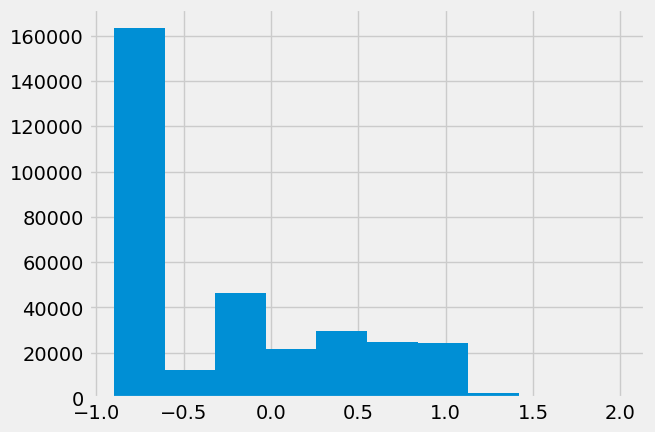

In [ ]:
# original data contains lots of promoters w/ no detected expression; bad distribution for modelling
plt.hist(df['Exp'])
plt.show()

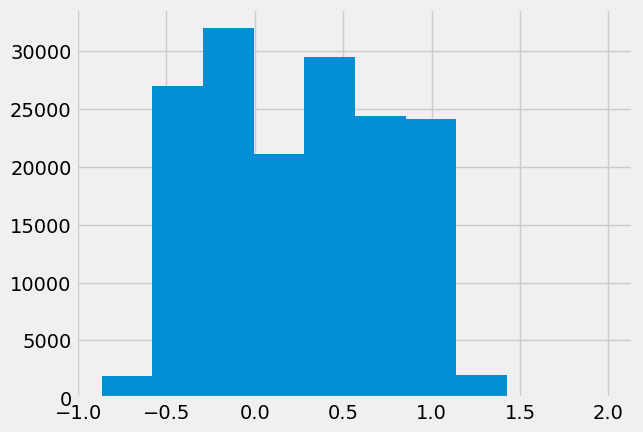

In [ ]:
#remove low outliers to get n. distribution
df = df[df['Exp']>-.89]
plt.hist(df['Exp'])
plt.show()

In [ ]:
#split dataset into training/test datasets
train_df, test_df = train_test_split(df)
#avoids issues with index down the line
train_df = train_df.reset_index()
test_df = test_df.reset_index()
#get max_length of the sequences in the dataset
max_length = df.Seqs.map(len).max()

In [ ]:
#use DnaLoader- this preprocesses the raw sequence and allows for batching data
train_loader = DataLoader(DnaDataset(train_df), batch_size=32, shuffle=True)
val_loader = DataLoader(DnaDataset(test_df), batch_size=32)

In [ ]:
#check if it worked...
letter,target = next(iter(train_loader))

In [ ]:
letter.shape

torch.Size([32, 6, 313])

In [ ]:
class min_cnn(nn.Module):
    """
    baseline CNN with a single convolution layer and dense layers
    
    input : shape with (# channels, sequence length)
    """
    def __init__(self, input_shape):
        super().__init__()
        
        self.input_channels = input_shape[0]
        self.input_length = input_shape[1]
        self.kernel_size = 5
        
        self.conv1 = nn.Conv1d(in_channels=self.input_channels,
                              out_channels=10,
                              kernel_size=self.kernel_size)
        self.relu1 = nn.ReLU()
        self.max1 = nn.MaxPool1d(2)
        
        dense_length = (self.input_length - (self.kernel_size - 1)) // 2
        
        self.flatten1 = nn.Flatten()
        
        self.lazy1 = nn.LazyLinear(1)
        self.linear1 = nn.Linear(in_features=dense_length*10,
                                out_features=1)
        
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max1(x)
        
        x = self.flatten1(x)
        #x = self.linear1(x)
        x = self.lazy1(x)
        lenx = len(x)
        return x.flatten()

In [ ]:
#check to see that the model works on a batch of data
model = min_cnn((6,313))
model(letter)

/home/glect/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([0.1543, 0.2171, 0.1390, 0.2300, 0.1518, 0.1682, 0.2044, 0.1809, 0.1355,
        0.1508, 0.2276, 0.0805, 0.2176, 0.2004, 0.1929, 0.1399, 0.1532, 0.2234,
        0.2117, 0.1531, 0.1329, 0.2065, 0.1913, 0.1981, 0.2825, 0.2123, 0.0176,
        0.1502, 0.1123, 0.2266, 0.2226, 0.1733],
       grad_fn=<ReshapeAliasBackward0>)

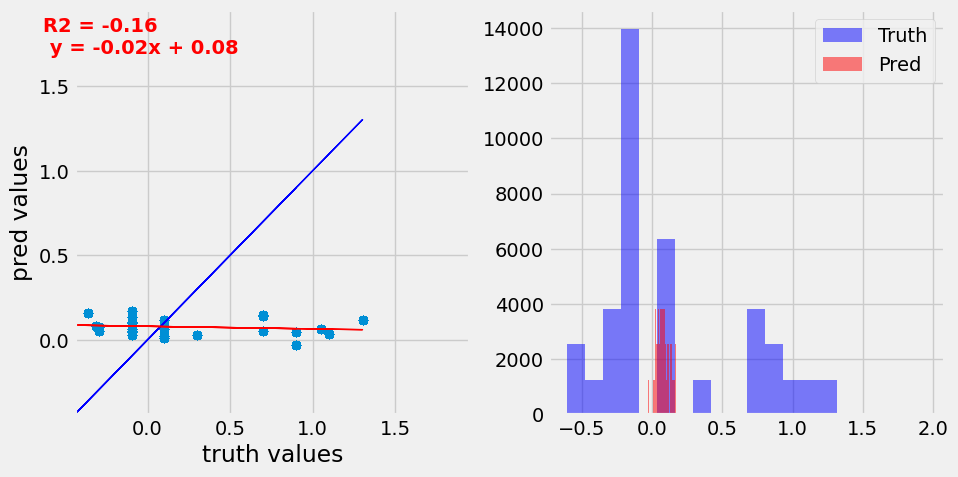

In [ ]:
#train the CNN on the dataset
model = min_cnn((6,313))
loss = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

sbs = StepByStep(model,loss,opt)
sbs.set_loaders(train_loader,val_loader)
#View the predictions by the model BEFORE training
x = pred_vs_truth(sbs,val_loader)

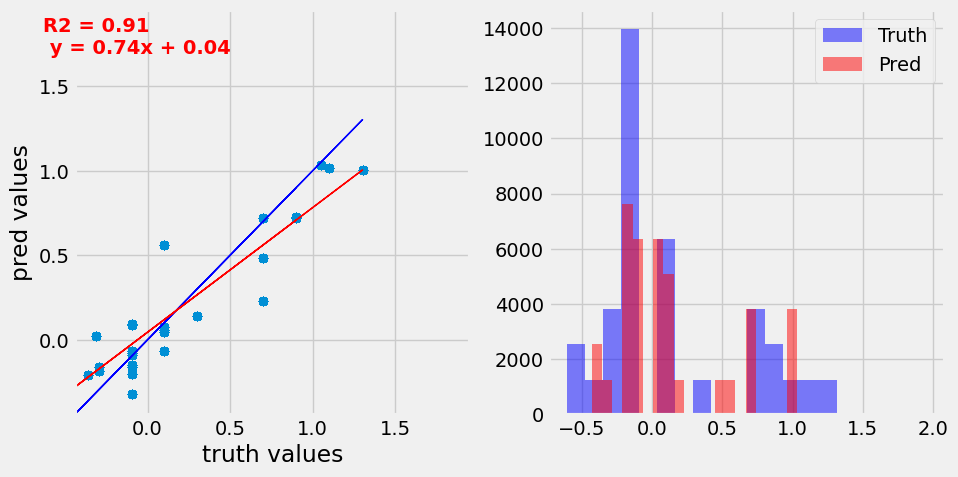

In [ ]:
#initiate training for 10 epochs
sbs.train(10)
#view the predictions AFTER training
x = pred_vs_truth(sbs,val_loader)

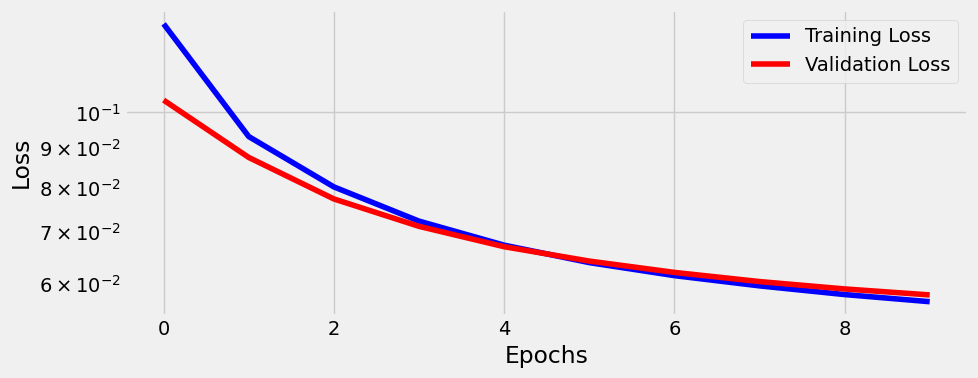

In [ ]:
#visualize the losses - still more to train but not important for this example case
sbs.plot_losses()

In [ ]:
from tqdm import tqdm

100%|██████████| 50/50 [00:04<00:00, 11.04it/s]


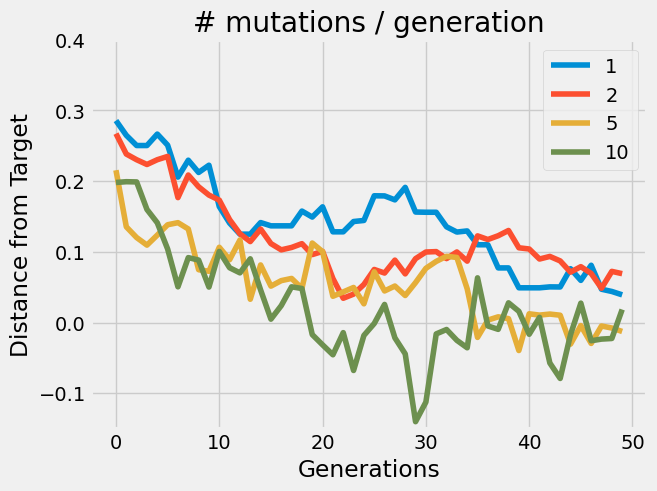

In [ ]:
class MitosisEvolve():
    """ 
    baseline Genetic Algorithm
    """
    def __init__(self, model, CC, seed, topN, target, nmuts, gens):
        self.model = model
        self.CC = CC # carry capacity / # individuals at a time
        self.seed = seed # original promoter sequence
        self.topN = topN # number to select each generation
        self.target = target # evolution target
        self.nmuts = nmuts #mutations per generation
        self.gen = gens
        
        #to evolve
        self.current_population = None
        self.current_score = None
        
        #to track
        self.stats = []
        self.generations = 0
        
    def snpMutate(self, start):
        """
        performs spontaneous SNP mutation
        input: a tokenized sequence
        """
        #copy or else it will modify the input sequence
        mutant = start.copy()
        #loop over designtated number of mutation/generation
        for i in range(self.nmuts):
            #pick random location in the sequence
            location = np.random.randint(len(mutant))
            #swap it out for a new base (maybe same one!)
            new_base = np.random.randint(low=1,high=5)
            mutant[location] = new_base
        return mutant
    
    def genPopulation(self,N):
        """
        generate novel individuals based on original seed promoter
        """
        new_pop = []
        #adds new individuals w/ novel mutation
        for i in range(N):
            new_pop.append(self.snpMutate(self.seed))
        return np.array(new_pop)
            
    def evolvePop(self):
        """
        takes in an array of individual promoters -> mutates each
        """
        new_pop = []
        for indiv in self.current_population:
            new_pop.append(self.snpMutate(indiv))
        return new_pop
    
    def scorePop(self):
        """
        runs each individual promoter through the CNN model to get a score
        
        returns list of scores -> corresponds to population list
        """
        scores = []
        for i in self.current_population:
            i = token2hot(i,len(i)) #might change this to init value self.max_length?
            i = i.swapaxes(0,1)
            scores.append(self.model.predict(i.unsqueeze(0))) #can probably do this in 1 batch
        return np.array(scores)
    
    def performSelection(self):
        """
        finds distance from the target value for each individual
        """
        #calculate fitness
        fitness = self.current_scores - np.array(self.target)
        fitness = fitness.flatten()
        
        #get top N individuals
        
        idx = np.argpartition(fitness,self.topN)
        survivors = idx[:self.topN]
        survivors = list(survivors)
        
        survivors = np.array(self.current_population)[survivors]
        
        return survivors
    
    def performMitosis(self):
        """
        Clones the best individuals for X number of rounds
        """
        rounds = 2
        clones = np.vstack((survivors,survivors))
        
        for i in range(rounds-1):
            clones = np.vstack((clones,survivors))
            
        return clones
    
    def evolve(self):
        """
        Runs the genetic algorithm from start to finish, with provided parameters
        """
        #initialize population
        init_pop = self.genPopulation(self.CC)
        self.current_population = init_pop
        score = 100
        
        for i in tqdm(range(self.gen)): # number of generations for now
            self.current_population = self.evolvePop()
            self.current_scores = self.scorePop()
            self.stats.append([self.current_scores.min(),self.current_scores.max(),self.current_scores.mean()])
            survivors = self.performSelection()
            N = self.CC - len(survivors)
            self.current_population = np.vstack((survivors,self.genPopulation(N)))
            
        self.stats = pd.DataFrame(self.stats)
        self.stats.columns = ['Min','Max','Mean']
        
    #VISUALIZATION
    def plot_fitness(self):
        plt.plot(range(len(evolver.stats)),evolver.stats['Min'],label = str(self.nmuts))

        
#This is the seed promoter which we wish to evolve to the target as chosen below
begin = hot2token(letter[0].swapaxes(0,1))

#runs the genetic algorithm w/ different values for mutations/generation then visualizes the results        
for x in [1,2,5,10]:
    evolver = MitosisEvolve(sbs, CC=200, seed=begin, topN=100, target = -0.9, nmuts=x, gens=50)
    evolver.evolve()
    evolver.plot_fitness()

plt.title('# mutations / generation')
plt.legend()
plt.ylim(-.15,0.4)
plt.xlabel('Generations')
plt.ylabel('Distance from Target')
plt.show()